<a href="https://colab.research.google.com/github/zp2226/E4511-2021-Zhanbo/blob/main/RF%26Peer_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

!pip install hyperopt

# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
# import numpy as np
# import pandas as pd
import os
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle

TensorFlow 1.x selected.
--2021-04-28 11:58:43--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   111MB/s    in 4.8s    

2021-04-28 11:58:48 (106 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bravado
    - molvs
    - mordred


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bravado-11.0.3        

In [11]:
! pip install bravado

  Using cached https://files.pythonhosted.org/packages/65/d4/f7407c3d15d5ac779c3dd34fbbc6ea2090f77bd7dd12f207ccf881551208/rfc3987-1.3.8-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/12/05/3350559de9714b202e443a9e6312937341bd5f79f4e4f625744295e7dd17/webcolors-1.11.1-py3-none-any.whl


In [12]:
# There is a problem with the previously imported cffi, so delete it and load it with AMPL instead
#if 'cffi' in sys.modules:
#  del sys.modules['cffi']
#import atomsci.ddm.pipeline.compare_models as cmp
from atomsci.ddm.pipeline import model_pipeline as mp
import atomsci.ddm.pipeline.compare_models as cmp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data
from atomsci.ddm.pipeline import model_wrapper
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [13]:
! wget https://raw.githubusercontent.com/zp2226/E4511-2021-Zhanbo/main/Data/DRD22_Merge.csv

--2021-04-28 12:08:45--  https://raw.githubusercontent.com/zp2226/E4511-2021-Zhanbo/main/Data/DRD22_Merge.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245572 (240K) [text/plain]
Saving to: ‘DRD22_Merge.csv.1’

DRD22_Merge.csv.1   100%[===================>] 239.82K  --.-KB/s    in 0.03s   

2021-04-28 12:08:45 (8.63 MB/s) - ‘DRD22_Merge.csv.1’ saved [245572/245572]



In [14]:
import pandas as pd
df = pd.read_csv('DRD22_Merge.csv', index_col=0)
df[df.compound_id.duplicated(keep=False)==True].sort_values(by='compound_id')
df_grouped = df.groupby('compound_id', as_index=False)['VALUE_NUM_mean'].mean()
df_dedup = df.drop_duplicates('compound_id')
df_avg = df_dedup.merge(df_grouped, left_on='compound_id', right_on='compound_id')
df_avg.drop('VALUE_NUM_mean_x', axis=1, inplace=True)
df_avg.rename(columns={'VALUE_NUM_mean_y': 'VALUE_NUM_mean'}, inplace=True)
df_avg

,compound_id,base_rdkit_smiles,relation,pXC50,active,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate,VALUE_NUM_mean
0,CHEMBL3394253,CCCN(CCCNC(=O)CCCC(=O)Oc1ccc(CCNc2nc(N)n3nc(-c...,NaN,6.317577,0,0.0,1.405885e-14,0,6.317577
1,CHEMBL1188090,CCCN(CCc1ccccc1)CCc1cccc(O)c1,NaN,7.408935,1,0.0,0.000000e+00,0,7.408935
2,CHEMBL3585373,CCCN(CCCNC(=O)CCC(=O)O)CCc1cccc2c1CC(=O)N2,NaN,5.330016,0,0.0,1.666371e-14,0,5.330016
3,CHEMBL633,CCCCc1oc2ccccc2c1C(=O)c1cc(I)c(OCCN(CC)CC)c(I)c1,NaN,4.700014,0,0.0,0.000000e+00,0,4.700014
4,CHEMBL3805165,CNC(=O)c1cccc(OCCCCN2CCN(c3cccc4c3OC(F)(F)O4)C...,NaN,8.387216,1,0.0,0.000000e+00,0,8.387216
...,...,...,...,...,...,...,...,...,...
2288,CHEMBL256481,Cc1ccc2c(-c3nnc(SCCCCN4CCc5cc6nc(C)oc6c(C)c5CC...,NaN,6.800000,0,NaN,0.000000e+00,0,6.800000
2289,CHEMBL110774,Clc1ccc(Cn2c(SCc3ccccc3)nc3ccccc32)cc1,NaN,5.170000,0,NaN,0.000000e+00,0,5.170000
2290,CHEMBL2057455,COc1cc2c(c(OC)c1)CN1CCc3cc(OC)c(O)cc3[C@@H]1C2,NaN,5.600000,0,NaN,0.000000e+00,0,5.600000
2291,CHEMBL111749,CNc1cc(OC)c(C(=O)N[C@H]2CN(Cc3ccccc3)C[C@@H]2C...,NaN,7.960000,1,NaN,0.000000e+00,0,7.960000


In [6]:
df_avg.to_csv('DRD22_Merge_1.csv')

In [38]:
#Split

working_dir = '/content'

In [39]:

# data splits based on the scaffold of small molecules.
featurizer = 'ecfp' 
model_type = 'RF'
response_col = ['VALUE_NUM_mean']
smiles_col = 'base_rdkit_smiles'
compound_id = 'compound_id'
train_file = "DRD22_Merge_1.csv"
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",   #Boolean flag for using an input file from the LLNL specific datastore system based on a key of dataset_key
        "save_results": "False", # Save model results to MongoDB,
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",  # Boolean flag for loading in previously split train, validation, and test csv files
        "split_only": "True",   # indicate splitting of the datasets when running the hyperparameter search
        'split_stategy':'train_valid_test',
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": working_dir
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-04-28 12:54:58,973 ['split_stategy'] are not part of the accepted list of parameters and will be ignored
2021-04-28 12:55:10,614 Splitting data by scaffold


number of features: 1024


2021-04-28 12:55:12,907 Dataset split table saved to /DRD22_Merge_1_train_valid_test_scaffold_54bcbc0a-687e-4e3b-bf97-d6458f2ad62a.csv


In [35]:
listing = glob.glob(os.path.join("/", "DRD22_Merge_1_train_valid_test_scaffold_*"))

In [36]:
listing

['/DRD22_Merge_1_train_valid_test_scaffold_58a49ebf-b65b-42e6-8e0d-bea9ce7b2474.csv',
 '/DRD22_Merge_1_train_valid_test_scaffold_e6cf22e0-751f-45bf-b15c-07b95976bc49.csv',
 '/DRD22_Merge_1_train_valid_test_scaffold_29595146-af92-46c0-b651-93c49fc0ffde.csv',
 '/DRD22_Merge_1_train_valid_test_scaffold_5d875ae3-5ec9-4b5b-9f7e-a9d7ce70eadf.csv']

In [40]:
# train inital rf model
name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "VALUE_NUM_mean"
# default : rf_estimators=500, rf_max_features = 32
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,   # UUID for csv file containing train, validation, and test split information
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output"
    }

In [41]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-28 12:55:54,188 Previous dataset split restored


TIMING: dataset construction took 0.124 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-04-28 12:56:03,775 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/63a999a4-f5c4-4859-ab89-9f2f1b4f6c8d/model_metadata.json
2021-04-28 12:56:04,646 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/63a999a4-f5c4-4859-ab89-9f2f1b4f6c8d/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_63a999a4-f5c4-4859-ab89-9f2f1b4f6c8d.tar.gz


In [ ]:

pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

In [43]:
pred_data = pl.model_wrapper.get_perf_data(subset="full", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of test set: {pred_results['r2_score']:.3f}")

R2 score of test set: -25.670


In [45]:
# The glob module finds all the pathnames matching a specified pattern according to the rules
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "VALUE_NUM_mean"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",       #Random forest
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',      # Maximum number of training epochs to run for DNN models. Default 30.
        "rerun": "False",
        "result_dir": "ampl_output",
        "uncertainty": "True"  # Boolean flag for computing uncertainty estimates for regression model predictions. 
    }

In [46]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-28 12:58:58,504 Previous dataset split restored


TIMING: dataset construction took 0.121 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 12:59:07,777 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/b099d673-85fd-40ae-a479-3ca10afe8f71/model_metadata.json
2021-04-28 12:59:08,686 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/b099d673-85fd-40ae-a479-3ca10afe8f71/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_b099d673-85fd-40ae-a479-3ca10afe8f71.tar.gz


In [47]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

R2 score of validation set: 0.356


In [ ]:
#GRIDE SEARCh

In [48]:
n_estimator = [150,300,400,500]
rf_max_depth = [15,70,150,250]
rf_max_features = [10,25,50,100]


rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in n_estimator:
    for rf_depth in rf_max_depth:
        for rf_feature in rf_max_features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

number of features: 1024


2021-04-28 13:00:05,735 Previous dataset split restored


TIMING: dataset construction took 0.120 s
Loading dataset from disk.
TIMING: dataset construction took 0.027 s
Loading dataset from disk.
TIMING: dataset construction took 0.028 s
Loading dataset from disk.


2021-04-28 13:00:08,040 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/035bd59d-4a4c-425c-8ac7-6cff15b5dd4c/model_metadata.json
2021-04-28 13:00:08,135 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/035bd59d-4a4c-425c-8ac7-6cff15b5dd4c/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_035bd59d-4a4c-425c-8ac7-6cff15b5dd4c.tar.gz
rf_estimators: 150, rf_max_depth: 15, rf_max_features: 10, valid_r2: 0.16110215150278184
number of features: 1024


2021-04-28 13:00:20,608 Previous dataset split restored


TIMING: dataset construction took 0.148 s
Loading dataset from disk.
TIMING: dataset construction took 0.030 s
Loading dataset from disk.
TIMING: dataset construction took 0.028 s
Loading dataset from disk.


2021-04-28 13:00:23,528 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/5fe7399f-7c44-4422-b10f-14bbb9a9f385/model_metadata.json
2021-04-28 13:00:23,626 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/5fe7399f-7c44-4422-b10f-14bbb9a9f385/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_5fe7399f-7c44-4422-b10f-14bbb9a9f385.tar.gz
rf_estimators: 150, rf_max_depth: 15, rf_max_features: 25, valid_r2: 0.23990561136320676
number of features: 1024


2021-04-28 13:00:35,790 Previous dataset split restored


TIMING: dataset construction took 0.127 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:00:38,682 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/1e54805f-c435-4f95-842e-435cec1ae747/model_metadata.json
2021-04-28 13:00:38,795 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/1e54805f-c435-4f95-842e-435cec1ae747/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_1e54805f-c435-4f95-842e-435cec1ae747.tar.gz
rf_estimators: 150, rf_max_depth: 15, rf_max_features: 50, valid_r2: 0.3005759464856109
number of features: 1024


2021-04-28 13:00:51,038 Previous dataset split restored


TIMING: dataset construction took 0.132 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:00:54,803 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/0d5d8452-749f-41d8-97a9-3f83e6ececee/model_metadata.json
2021-04-28 13:00:54,900 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/0d5d8452-749f-41d8-97a9-3f83e6ececee/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_0d5d8452-749f-41d8-97a9-3f83e6ececee.tar.gz
rf_estimators: 150, rf_max_depth: 15, rf_max_features: 100, valid_r2: 0.3148698022079566
number of features: 1024


2021-04-28 13:01:07,340 Previous dataset split restored


TIMING: dataset construction took 0.122 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:01:10,745 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/d3bf51cd-9468-42af-be03-3f3ddfb60859/model_metadata.json
2021-04-28 13:01:11,022 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/d3bf51cd-9468-42af-be03-3f3ddfb60859/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_d3bf51cd-9468-42af-be03-3f3ddfb60859.tar.gz
rf_estimators: 150, rf_max_depth: 70, rf_max_features: 10, valid_r2: 0.3145490077181591
number of features: 1024


2021-04-28 13:01:23,292 Previous dataset split restored


TIMING: dataset construction took 0.134 s
Loading dataset from disk.
TIMING: dataset construction took 0.030 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.


2021-04-28 13:01:26,897 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/47080626-2f6b-42dc-8d3e-a0640e4b7f53/model_metadata.json
2021-04-28 13:01:27,174 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/47080626-2f6b-42dc-8d3e-a0640e4b7f53/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_47080626-2f6b-42dc-8d3e-a0640e4b7f53.tar.gz
rf_estimators: 150, rf_max_depth: 70, rf_max_features: 25, valid_r2: 0.3358576193992113
number of features: 1024


2021-04-28 13:01:39,431 Previous dataset split restored


TIMING: dataset construction took 0.134 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-04-28 13:01:43,465 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/2b21c0b5-0006-4b71-a9cf-19d7a7e3ab81/model_metadata.json
2021-04-28 13:01:43,741 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/2b21c0b5-0006-4b71-a9cf-19d7a7e3ab81/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_2b21c0b5-0006-4b71-a9cf-19d7a7e3ab81.tar.gz
rf_estimators: 150, rf_max_depth: 70, rf_max_features: 50, valid_r2: 0.3813019143559436
number of features: 1024


2021-04-28 13:01:56,001 Previous dataset split restored


TIMING: dataset construction took 0.133 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:02:01,282 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/bb994340-7542-47bf-9964-6b869e69ef37/model_metadata.json
2021-04-28 13:02:01,556 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/bb994340-7542-47bf-9964-6b869e69ef37/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_bb994340-7542-47bf-9964-6b869e69ef37.tar.gz
rf_estimators: 150, rf_max_depth: 70, rf_max_features: 100, valid_r2: 0.3933379738597891
number of features: 1024


2021-04-28 13:02:14,029 Previous dataset split restored


TIMING: dataset construction took 0.126 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:02:17,195 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/a1226819-c0e7-4112-8f96-791f89c1357e/model_metadata.json
2021-04-28 13:02:17,462 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/a1226819-c0e7-4112-8f96-791f89c1357e/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_a1226819-c0e7-4112-8f96-791f89c1357e.tar.gz
rf_estimators: 150, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.28857922247565027
number of features: 1024


2021-04-28 13:02:29,675 Previous dataset split restored


TIMING: dataset construction took 0.125 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:02:33,220 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/a58fc4ef-583c-45ab-b222-45316ac46558/model_metadata.json
2021-04-28 13:02:33,488 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/a58fc4ef-583c-45ab-b222-45316ac46558/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_a58fc4ef-583c-45ab-b222-45316ac46558.tar.gz
rf_estimators: 150, rf_max_depth: 150, rf_max_features: 25, valid_r2: 0.35798392966201065
number of features: 1024


2021-04-28 13:02:45,912 Previous dataset split restored


TIMING: dataset construction took 0.155 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:02:50,110 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/abc7d1dc-b095-4f09-b60d-5fb1535f26b2/model_metadata.json
2021-04-28 13:02:50,388 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/abc7d1dc-b095-4f09-b60d-5fb1535f26b2/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_abc7d1dc-b095-4f09-b60d-5fb1535f26b2.tar.gz
rf_estimators: 150, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.3639538590455479
number of features: 1024


2021-04-28 13:03:02,939 Previous dataset split restored


TIMING: dataset construction took 0.128 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:03:08,116 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/5b0db193-cca5-4803-985d-07ecc5486ff5/model_metadata.json
2021-04-28 13:03:08,406 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/5b0db193-cca5-4803-985d-07ecc5486ff5/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_5b0db193-cca5-4803-985d-07ecc5486ff5.tar.gz
rf_estimators: 150, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.3663760775918331
number of features: 1024


2021-04-28 13:03:21,013 Previous dataset split restored


TIMING: dataset construction took 0.155 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.
TIMING: dataset construction took 0.027 s
Loading dataset from disk.


2021-04-28 13:03:24,634 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/6e872c65-ae9f-4949-b1b5-8534470b7093/model_metadata.json
2021-04-28 13:03:24,950 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/6e872c65-ae9f-4949-b1b5-8534470b7093/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_6e872c65-ae9f-4949-b1b5-8534470b7093.tar.gz
rf_estimators: 150, rf_max_depth: 250, rf_max_features: 10, valid_r2: 0.2907514649218258
number of features: 1024


2021-04-28 13:03:37,601 Previous dataset split restored


TIMING: dataset construction took 0.122 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:03:41,140 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/86b5144e-ccee-4924-b031-fc283efdaf59/model_metadata.json
2021-04-28 13:03:41,438 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/86b5144e-ccee-4924-b031-fc283efdaf59/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_86b5144e-ccee-4924-b031-fc283efdaf59.tar.gz
rf_estimators: 150, rf_max_depth: 250, rf_max_features: 25, valid_r2: 0.3376915278409287
number of features: 1024


2021-04-28 13:03:53,524 Previous dataset split restored


TIMING: dataset construction took 0.121 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:03:57,601 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/83945a4e-bb8a-4aac-93b6-14b3953705f7/model_metadata.json
2021-04-28 13:03:57,871 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/83945a4e-bb8a-4aac-93b6-14b3953705f7/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_83945a4e-bb8a-4aac-93b6-14b3953705f7.tar.gz
rf_estimators: 150, rf_max_depth: 250, rf_max_features: 50, valid_r2: 0.36006596349667475
number of features: 1024


2021-04-28 13:04:10,333 Previous dataset split restored


TIMING: dataset construction took 0.123 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:04:15,366 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/f158bc89-1f44-4c51-b49d-373a11b3ec77/model_metadata.json
2021-04-28 13:04:15,630 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/f158bc89-1f44-4c51-b49d-373a11b3ec77/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_f158bc89-1f44-4c51-b49d-373a11b3ec77.tar.gz
rf_estimators: 150, rf_max_depth: 250, rf_max_features: 100, valid_r2: 0.38679438585995507
number of features: 1024


2021-04-28 13:04:27,993 Previous dataset split restored


TIMING: dataset construction took 0.121 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:04:31,414 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/7ca8f088-3e21-41a1-ac8e-b2d24e85ea6c/model_metadata.json
2021-04-28 13:04:31,578 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/7ca8f088-3e21-41a1-ac8e-b2d24e85ea6c/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_7ca8f088-3e21-41a1-ac8e-b2d24e85ea6c.tar.gz
rf_estimators: 300, rf_max_depth: 15, rf_max_features: 10, valid_r2: 0.15460246813744782
number of features: 1024


2021-04-28 13:04:44,285 Previous dataset split restored


TIMING: dataset construction took 0.155 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-04-28 13:04:48,314 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/a60a531f-d38c-4500-a97e-2fb902345538/model_metadata.json
2021-04-28 13:04:48,503 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/a60a531f-d38c-4500-a97e-2fb902345538/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_a60a531f-d38c-4500-a97e-2fb902345538.tar.gz
rf_estimators: 300, rf_max_depth: 15, rf_max_features: 25, valid_r2: 0.2294840244016111
number of features: 1024


2021-04-28 13:05:00,970 Previous dataset split restored


TIMING: dataset construction took 0.134 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:05:05,788 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/0d9e3ab3-1177-4a06-ad24-a38458db142f/model_metadata.json
2021-04-28 13:05:05,992 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/0d9e3ab3-1177-4a06-ad24-a38458db142f/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_0d9e3ab3-1177-4a06-ad24-a38458db142f.tar.gz
rf_estimators: 300, rf_max_depth: 15, rf_max_features: 50, valid_r2: 0.2880479021518976
number of features: 1024


2021-04-28 13:05:19,293 Previous dataset split restored


TIMING: dataset construction took 0.131 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:05:25,416 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/261ba2db-2ddf-4329-b449-4dc518a0b81c/model_metadata.json
2021-04-28 13:05:25,616 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/261ba2db-2ddf-4329-b449-4dc518a0b81c/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_261ba2db-2ddf-4329-b449-4dc518a0b81c.tar.gz
rf_estimators: 300, rf_max_depth: 15, rf_max_features: 100, valid_r2: 0.33803875579846
number of features: 1024


2021-04-28 13:05:38,166 Previous dataset split restored


TIMING: dataset construction took 0.133 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:05:43,381 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/3c5d6aa2-d718-44ee-8e76-25a02d7519b6/model_metadata.json
2021-04-28 13:05:43,938 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/3c5d6aa2-d718-44ee-8e76-25a02d7519b6/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_3c5d6aa2-d718-44ee-8e76-25a02d7519b6.tar.gz
rf_estimators: 300, rf_max_depth: 70, rf_max_features: 10, valid_r2: 0.30374887022357866
number of features: 1024


2021-04-28 13:05:56,161 Previous dataset split restored


TIMING: dataset construction took 0.123 s
Loading dataset from disk.
TIMING: dataset construction took 0.041 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-04-28 13:06:01,925 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/77607e4d-f6af-42b3-938d-3e12e932b146/model_metadata.json
2021-04-28 13:06:02,487 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/77607e4d-f6af-42b3-938d-3e12e932b146/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_77607e4d-f6af-42b3-938d-3e12e932b146.tar.gz
rf_estimators: 300, rf_max_depth: 70, rf_max_features: 25, valid_r2: 0.35105453124608166
number of features: 1024


2021-04-28 13:06:14,741 Previous dataset split restored


TIMING: dataset construction took 0.164 s
Loading dataset from disk.
TIMING: dataset construction took 0.029 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.


2021-04-28 13:06:21,576 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/75ab42bc-bed1-4842-9fcd-a83d067acb26/model_metadata.json
2021-04-28 13:06:22,124 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/75ab42bc-bed1-4842-9fcd-a83d067acb26/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_75ab42bc-bed1-4842-9fcd-a83d067acb26.tar.gz
rf_estimators: 300, rf_max_depth: 70, rf_max_features: 50, valid_r2: 0.3546991917937298
number of features: 1024


2021-04-28 13:06:34,563 Previous dataset split restored


TIMING: dataset construction took 0.126 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:06:43,435 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/33eb4682-48c3-4186-932f-3d1eec6d96d5/model_metadata.json
2021-04-28 13:06:43,945 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/33eb4682-48c3-4186-932f-3d1eec6d96d5/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_33eb4682-48c3-4186-932f-3d1eec6d96d5.tar.gz
rf_estimators: 300, rf_max_depth: 70, rf_max_features: 100, valid_r2: 0.3882539327729061
number of features: 1024


2021-04-28 13:06:56,177 Previous dataset split restored


TIMING: dataset construction took 0.122 s
Loading dataset from disk.
TIMING: dataset construction took 0.027 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:07:01,351 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/6c4c4e29-1cad-4435-95b1-9977a820d475/model_metadata.json
2021-04-28 13:07:01,891 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/6c4c4e29-1cad-4435-95b1-9977a820d475/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_6c4c4e29-1cad-4435-95b1-9977a820d475.tar.gz
rf_estimators: 300, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.3084177621124523
number of features: 1024


2021-04-28 13:07:14,096 Previous dataset split restored


TIMING: dataset construction took 0.129 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:07:19,788 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/ceb3b29f-3d5b-4c8e-af61-4dd4efff5d3f/model_metadata.json
2021-04-28 13:07:20,374 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/ceb3b29f-3d5b-4c8e-af61-4dd4efff5d3f/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_ceb3b29f-3d5b-4c8e-af61-4dd4efff5d3f.tar.gz
rf_estimators: 300, rf_max_depth: 150, rf_max_features: 25, valid_r2: 0.3349388443167963
number of features: 1024


2021-04-28 13:07:32,730 Previous dataset split restored


TIMING: dataset construction took 0.131 s
Loading dataset from disk.
TIMING: dataset construction took 0.027 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.


2021-04-28 13:07:39,612 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/167f2631-4f82-4185-b5f2-0cd50b59614c/model_metadata.json
2021-04-28 13:07:40,163 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/167f2631-4f82-4185-b5f2-0cd50b59614c/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_167f2631-4f82-4185-b5f2-0cd50b59614c.tar.gz
rf_estimators: 300, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.362239033812496
number of features: 1024


2021-04-28 13:07:52,612 Previous dataset split restored


TIMING: dataset construction took 0.125 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:08:01,444 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/fc76f48d-c7a4-4c3d-bc0f-609bb59601a2/model_metadata.json
2021-04-28 13:08:01,985 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/fc76f48d-c7a4-4c3d-bc0f-609bb59601a2/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_fc76f48d-c7a4-4c3d-bc0f-609bb59601a2.tar.gz
rf_estimators: 300, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.3914560853883492
number of features: 1024


2021-04-28 13:08:14,412 Previous dataset split restored


TIMING: dataset construction took 0.117 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:08:19,456 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/15d48689-5de0-4a44-b6ee-19550d3e613b/model_metadata.json
2021-04-28 13:08:20,008 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/15d48689-5de0-4a44-b6ee-19550d3e613b/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_15d48689-5de0-4a44-b6ee-19550d3e613b.tar.gz
rf_estimators: 300, rf_max_depth: 250, rf_max_features: 10, valid_r2: 0.2981881612935764
number of features: 1024


2021-04-28 13:08:32,658 Previous dataset split restored


TIMING: dataset construction took 0.118 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:08:38,411 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/2c0e6f1b-6948-4d26-9072-1d74cb16744d/model_metadata.json
2021-04-28 13:08:38,946 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/2c0e6f1b-6948-4d26-9072-1d74cb16744d/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_2c0e6f1b-6948-4d26-9072-1d74cb16744d.tar.gz
rf_estimators: 300, rf_max_depth: 250, rf_max_features: 25, valid_r2: 0.32594347024926185
number of features: 1024


2021-04-28 13:08:51,868 Previous dataset split restored


TIMING: dataset construction took 0.131 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.


2021-04-28 13:08:58,633 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/d9175b64-4f47-45fd-a15c-79ba82d21ff2/model_metadata.json
2021-04-28 13:08:59,177 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/d9175b64-4f47-45fd-a15c-79ba82d21ff2/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_d9175b64-4f47-45fd-a15c-79ba82d21ff2.tar.gz
rf_estimators: 300, rf_max_depth: 250, rf_max_features: 50, valid_r2: 0.3655793091455236
number of features: 1024


2021-04-28 13:09:11,847 Previous dataset split restored


TIMING: dataset construction took 0.149 s
Loading dataset from disk.
TIMING: dataset construction took 0.029 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-04-28 13:09:21,099 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/5b303d0e-435f-48fc-a7d6-eca47d119885/model_metadata.json
2021-04-28 13:09:21,702 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/5b303d0e-435f-48fc-a7d6-eca47d119885/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_5b303d0e-435f-48fc-a7d6-eca47d119885.tar.gz
rf_estimators: 300, rf_max_depth: 250, rf_max_features: 100, valid_r2: 0.3878117401393789
number of features: 1024


2021-04-28 13:09:34,968 Previous dataset split restored


TIMING: dataset construction took 0.120 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.
TIMING: dataset construction took 0.027 s
Loading dataset from disk.


2021-04-28 13:09:39,320 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/8438963b-3c45-449f-9cff-67f23cc48986/model_metadata.json
2021-04-28 13:09:39,551 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/8438963b-3c45-449f-9cff-67f23cc48986/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_8438963b-3c45-449f-9cff-67f23cc48986.tar.gz
rf_estimators: 400, rf_max_depth: 15, rf_max_features: 10, valid_r2: 0.15466461093009254
number of features: 1024


2021-04-28 13:09:52,317 Previous dataset split restored


TIMING: dataset construction took 0.144 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.


2021-04-28 13:09:57,510 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/ee581bc3-7a67-4f2e-bad8-fe27a80684ac/model_metadata.json
2021-04-28 13:09:57,767 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/ee581bc3-7a67-4f2e-bad8-fe27a80684ac/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_ee581bc3-7a67-4f2e-bad8-fe27a80684ac.tar.gz
rf_estimators: 400, rf_max_depth: 15, rf_max_features: 25, valid_r2: 0.24559768884475408
number of features: 1024


2021-04-28 13:10:10,571 Previous dataset split restored


TIMING: dataset construction took 0.127 s
Loading dataset from disk.
TIMING: dataset construction took 0.028 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.


2021-04-28 13:10:16,805 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/7a524450-0a0a-464b-9824-7abc98b5f0fe/model_metadata.json
2021-04-28 13:10:17,065 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/7a524450-0a0a-464b-9824-7abc98b5f0fe/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_7a524450-0a0a-464b-9824-7abc98b5f0fe.tar.gz
rf_estimators: 400, rf_max_depth: 15, rf_max_features: 50, valid_r2: 0.2986067484287058
number of features: 1024


2021-04-28 13:10:30,217 Previous dataset split restored


TIMING: dataset construction took 0.143 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:10:38,303 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/7bef6c7f-ffee-414b-8e10-eeaf2f034e35/model_metadata.json
2021-04-28 13:10:38,581 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/7bef6c7f-ffee-414b-8e10-eeaf2f034e35/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_7bef6c7f-ffee-414b-8e10-eeaf2f034e35.tar.gz
rf_estimators: 400, rf_max_depth: 15, rf_max_features: 100, valid_r2: 0.3252461693227289
number of features: 1024


2021-04-28 13:10:51,694 Previous dataset split restored


TIMING: dataset construction took 0.143 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.


2021-04-28 13:10:58,155 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/4cb528a3-1c56-48bb-bc07-4cb6828610bc/model_metadata.json
2021-04-28 13:10:58,891 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/4cb528a3-1c56-48bb-bc07-4cb6828610bc/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_4cb528a3-1c56-48bb-bc07-4cb6828610bc.tar.gz
rf_estimators: 400, rf_max_depth: 70, rf_max_features: 10, valid_r2: 0.3017873054338016
number of features: 1024


2021-04-28 13:11:11,128 Previous dataset split restored


TIMING: dataset construction took 0.135 s
Loading dataset from disk.
TIMING: dataset construction took 0.027 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.


2021-04-28 13:11:18,583 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/072ba50b-2ae4-40b4-9402-948ac2b32dc6/model_metadata.json
2021-04-28 13:11:19,286 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/072ba50b-2ae4-40b4-9402-948ac2b32dc6/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_072ba50b-2ae4-40b4-9402-948ac2b32dc6.tar.gz
rf_estimators: 400, rf_max_depth: 70, rf_max_features: 25, valid_r2: 0.34116586014309014
number of features: 1024


2021-04-28 13:11:31,819 Previous dataset split restored


TIMING: dataset construction took 0.131 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-04-28 13:11:40,668 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/ca2e2884-1b70-4400-bc34-577ea9315194/model_metadata.json
2021-04-28 13:11:41,371 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/ca2e2884-1b70-4400-bc34-577ea9315194/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_ca2e2884-1b70-4400-bc34-577ea9315194.tar.gz
rf_estimators: 400, rf_max_depth: 70, rf_max_features: 50, valid_r2: 0.36956064570317815
number of features: 1024


2021-04-28 13:11:53,691 Previous dataset split restored


TIMING: dataset construction took 0.121 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-04-28 13:12:05,303 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/de4a3354-2653-4990-8e26-2ecf96758c5d/model_metadata.json
2021-04-28 13:12:06,009 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/de4a3354-2653-4990-8e26-2ecf96758c5d/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_de4a3354-2653-4990-8e26-2ecf96758c5d.tar.gz
rf_estimators: 400, rf_max_depth: 70, rf_max_features: 100, valid_r2: 0.38754691909859784
number of features: 1024


2021-04-28 13:12:18,238 Previous dataset split restored


TIMING: dataset construction took 0.127 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:12:24,918 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/92f93525-82be-47ca-ae88-8ef26f740d0e/model_metadata.json
2021-04-28 13:12:25,651 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/92f93525-82be-47ca-ae88-8ef26f740d0e/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_92f93525-82be-47ca-ae88-8ef26f740d0e.tar.gz
rf_estimators: 400, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.3045047083091098
number of features: 1024


2021-04-28 13:12:37,721 Previous dataset split restored


TIMING: dataset construction took 0.120 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-04-28 13:12:44,896 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/74242ed6-00e6-4032-b102-3ab692073e6b/model_metadata.json
2021-04-28 13:12:45,611 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/74242ed6-00e6-4032-b102-3ab692073e6b/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_74242ed6-00e6-4032-b102-3ab692073e6b.tar.gz
rf_estimators: 400, rf_max_depth: 150, rf_max_features: 25, valid_r2: 0.3485736807807034
number of features: 1024


2021-04-28 13:12:57,628 Previous dataset split restored


TIMING: dataset construction took 0.136 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.027 s
Loading dataset from disk.


2021-04-28 13:13:06,327 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/e6fc44d9-7c38-423e-8b2f-84f4bfb81d96/model_metadata.json
2021-04-28 13:13:07,035 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/e6fc44d9-7c38-423e-8b2f-84f4bfb81d96/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_e6fc44d9-7c38-423e-8b2f-84f4bfb81d96.tar.gz
rf_estimators: 400, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.3760543177009318
number of features: 1024


2021-04-28 13:13:19,083 Previous dataset split restored


TIMING: dataset construction took 0.118 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:13:31,635 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/d9e1c93b-55b2-448e-9107-7c395e716776/model_metadata.json
2021-04-28 13:13:32,319 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/d9e1c93b-55b2-448e-9107-7c395e716776/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_d9e1c93b-55b2-448e-9107-7c395e716776.tar.gz
rf_estimators: 400, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.39183668085582224
number of features: 1024


2021-04-28 13:13:45,010 Previous dataset split restored


TIMING: dataset construction took 0.138 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-04-28 13:13:51,831 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/1aacf8fa-fdd2-47f0-a321-fa0dabb72172/model_metadata.json
2021-04-28 13:13:52,558 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/1aacf8fa-fdd2-47f0-a321-fa0dabb72172/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_1aacf8fa-fdd2-47f0-a321-fa0dabb72172.tar.gz
rf_estimators: 400, rf_max_depth: 250, rf_max_features: 10, valid_r2: 0.3018602849988352
number of features: 1024


2021-04-28 13:14:05,693 Previous dataset split restored


TIMING: dataset construction took 0.139 s
Loading dataset from disk.
TIMING: dataset construction took 0.040 s
Loading dataset from disk.
TIMING: dataset construction took 0.031 s
Loading dataset from disk.


2021-04-28 13:14:13,494 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/750b43c8-2a76-44b6-bb7b-13fdfa05a37b/model_metadata.json
2021-04-28 13:14:14,208 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/750b43c8-2a76-44b6-bb7b-13fdfa05a37b/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_750b43c8-2a76-44b6-bb7b-13fdfa05a37b.tar.gz
rf_estimators: 400, rf_max_depth: 250, rf_max_features: 25, valid_r2: 0.34352780052981446
number of features: 1024


2021-04-28 13:14:26,325 Previous dataset split restored


TIMING: dataset construction took 0.130 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-04-28 13:14:35,050 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/d45f61ec-99eb-4f2b-974c-c32b52ddf739/model_metadata.json
2021-04-28 13:14:35,776 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/d45f61ec-99eb-4f2b-974c-c32b52ddf739/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_d45f61ec-99eb-4f2b-974c-c32b52ddf739.tar.gz
rf_estimators: 400, rf_max_depth: 250, rf_max_features: 50, valid_r2: 0.3669665015574961
number of features: 1024


2021-04-28 13:14:47,899 Previous dataset split restored


TIMING: dataset construction took 0.116 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:14:59,185 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/fc3f8f57-903d-4920-8ca9-fa03a0fa67ab/model_metadata.json
2021-04-28 13:14:59,876 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/fc3f8f57-903d-4920-8ca9-fa03a0fa67ab/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_fc3f8f57-903d-4920-8ca9-fa03a0fa67ab.tar.gz
rf_estimators: 400, rf_max_depth: 250, rf_max_features: 100, valid_r2: 0.38499328336231964
number of features: 1024


2021-04-28 13:15:12,036 Previous dataset split restored


TIMING: dataset construction took 0.123 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:15:16,937 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/687089c6-f891-44b8-80db-0817f182b000/model_metadata.json
2021-04-28 13:15:17,236 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/687089c6-f891-44b8-80db-0817f182b000/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_687089c6-f891-44b8-80db-0817f182b000.tar.gz
rf_estimators: 500, rf_max_depth: 15, rf_max_features: 10, valid_r2: 0.15775360020329976
number of features: 1024


2021-04-28 13:15:29,495 Previous dataset split restored


TIMING: dataset construction took 0.124 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.


2021-04-28 13:15:35,397 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/0b2f77b2-73d1-4574-93e9-876f460df123/model_metadata.json
2021-04-28 13:15:35,720 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/0b2f77b2-73d1-4574-93e9-876f460df123/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_0b2f77b2-73d1-4574-93e9-876f460df123.tar.gz
rf_estimators: 500, rf_max_depth: 15, rf_max_features: 25, valid_r2: 0.23588900032092197
number of features: 1024


2021-04-28 13:15:47,948 Previous dataset split restored


TIMING: dataset construction took 0.126 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.


2021-04-28 13:15:54,798 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/1889143d-5d2c-4b13-9c86-0f1a59e8c233/model_metadata.json
2021-04-28 13:15:55,110 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/1889143d-5d2c-4b13-9c86-0f1a59e8c233/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_1889143d-5d2c-4b13-9c86-0f1a59e8c233.tar.gz
rf_estimators: 500, rf_max_depth: 15, rf_max_features: 50, valid_r2: 0.2891842137011247
number of features: 1024


2021-04-28 13:16:07,118 Previous dataset split restored


TIMING: dataset construction took 0.120 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:16:16,156 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/441bcfba-f51b-4779-8d93-01f59987c60c/model_metadata.json
2021-04-28 13:16:16,472 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/441bcfba-f51b-4779-8d93-01f59987c60c/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_441bcfba-f51b-4779-8d93-01f59987c60c.tar.gz
rf_estimators: 500, rf_max_depth: 15, rf_max_features: 100, valid_r2: 0.33005696809947926
number of features: 1024


2021-04-28 13:16:28,462 Previous dataset split restored


TIMING: dataset construction took 0.118 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:16:36,170 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/f193f801-74f6-4b34-9313-8fcdb687c121/model_metadata.json
2021-04-28 13:16:37,041 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/f193f801-74f6-4b34-9313-8fcdb687c121/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_f193f801-74f6-4b34-9313-8fcdb687c121.tar.gz
rf_estimators: 500, rf_max_depth: 70, rf_max_features: 10, valid_r2: 0.309244903189158
number of features: 1024


2021-04-28 13:16:49,062 Previous dataset split restored


TIMING: dataset construction took 0.125 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:16:57,764 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/22468278-5c58-4a61-9501-ca9bcb652b50/model_metadata.json
2021-04-28 13:16:58,659 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/22468278-5c58-4a61-9501-ca9bcb652b50/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_22468278-5c58-4a61-9501-ca9bcb652b50.tar.gz
rf_estimators: 500, rf_max_depth: 70, rf_max_features: 25, valid_r2: 0.33483953703321234
number of features: 1024


2021-04-28 13:17:10,796 Previous dataset split restored


TIMING: dataset construction took 0.117 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:17:21,403 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/5b5eb3d6-455e-47d6-b372-23cc8ba4a21d/model_metadata.json
2021-04-28 13:17:22,296 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/5b5eb3d6-455e-47d6-b372-23cc8ba4a21d/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_5b5eb3d6-455e-47d6-b372-23cc8ba4a21d.tar.gz
rf_estimators: 500, rf_max_depth: 70, rf_max_features: 50, valid_r2: 0.37853626108463645
number of features: 1024


2021-04-28 13:17:34,563 Previous dataset split restored


TIMING: dataset construction took 0.122 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:17:48,353 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/b68074de-1821-45a3-9108-42a06ee3a039/model_metadata.json
2021-04-28 13:17:49,225 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/b68074de-1821-45a3-9108-42a06ee3a039/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_b68074de-1821-45a3-9108-42a06ee3a039.tar.gz
rf_estimators: 500, rf_max_depth: 70, rf_max_features: 100, valid_r2: 0.38981155567067705
number of features: 1024


2021-04-28 13:18:01,208 Previous dataset split restored


TIMING: dataset construction took 0.125 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-04-28 13:18:08,833 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/1958642b-3754-4f23-b48f-1f6ce30f020e/model_metadata.json
2021-04-28 13:18:09,739 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/1958642b-3754-4f23-b48f-1f6ce30f020e/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_1958642b-3754-4f23-b48f-1f6ce30f020e.tar.gz
rf_estimators: 500, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.3155693641347185
number of features: 1024


2021-04-28 13:18:21,923 Previous dataset split restored


TIMING: dataset construction took 0.121 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.


2021-04-28 13:18:30,680 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/aa547886-1f8c-4ca4-b6d5-9ce773ac1b0d/model_metadata.json
2021-04-28 13:18:31,549 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/aa547886-1f8c-4ca4-b6d5-9ce773ac1b0d/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_aa547886-1f8c-4ca4-b6d5-9ce773ac1b0d.tar.gz
rf_estimators: 500, rf_max_depth: 150, rf_max_features: 25, valid_r2: 0.3465716780465382
number of features: 1024


2021-04-28 13:18:43,599 Previous dataset split restored


TIMING: dataset construction took 0.126 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:18:54,054 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/987f4e3f-dc05-4689-81a2-4a672433e562/model_metadata.json
2021-04-28 13:18:54,926 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/987f4e3f-dc05-4689-81a2-4a672433e562/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_987f4e3f-dc05-4689-81a2-4a672433e562.tar.gz
rf_estimators: 500, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.37554649809464
number of features: 1024


2021-04-28 13:19:06,943 Previous dataset split restored


TIMING: dataset construction took 0.138 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-04-28 13:19:21,028 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/67c62dae-ecb2-4061-9842-293f3928cff6/model_metadata.json
2021-04-28 13:19:21,949 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/67c62dae-ecb2-4061-9842-293f3928cff6/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_67c62dae-ecb2-4061-9842-293f3928cff6.tar.gz
rf_estimators: 500, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.3897872472329815
number of features: 1024


2021-04-28 13:19:34,325 Previous dataset split restored


TIMING: dataset construction took 0.121 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:19:41,943 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/968e97c7-fdf8-4f69-98ae-e506f0a9da8a/model_metadata.json
2021-04-28 13:19:42,821 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/968e97c7-fdf8-4f69-98ae-e506f0a9da8a/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_968e97c7-fdf8-4f69-98ae-e506f0a9da8a.tar.gz
rf_estimators: 500, rf_max_depth: 250, rf_max_features: 10, valid_r2: 0.31335524748860166
number of features: 1024


2021-04-28 13:19:54,857 Previous dataset split restored


TIMING: dataset construction took 0.126 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.


2021-04-28 13:20:03,374 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/8eaf432b-ff54-4cf0-8f15-d12d003c5f0f/model_metadata.json
2021-04-28 13:20:04,275 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/8eaf432b-ff54-4cf0-8f15-d12d003c5f0f/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_8eaf432b-ff54-4cf0-8f15-d12d003c5f0f.tar.gz
rf_estimators: 500, rf_max_depth: 250, rf_max_features: 25, valid_r2: 0.3441886116162467
number of features: 1024


2021-04-28 13:20:16,347 Previous dataset split restored


TIMING: dataset construction took 0.119 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.


2021-04-28 13:20:26,933 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/58158465-6650-48e7-b49e-d56b81cecc37/model_metadata.json
2021-04-28 13:20:27,786 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/58158465-6650-48e7-b49e-d56b81cecc37/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_58158465-6650-48e7-b49e-d56b81cecc37.tar.gz
rf_estimators: 500, rf_max_depth: 250, rf_max_features: 50, valid_r2: 0.35978809952017066
number of features: 1024


2021-04-28 13:20:39,722 Previous dataset split restored


TIMING: dataset construction took 0.118 s
Loading dataset from disk.
TIMING: dataset construction took 0.027 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.


2021-04-28 13:20:53,407 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/6671bbf0-eda3-4970-b17b-bbad90e36095/model_metadata.json
2021-04-28 13:20:54,261 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/6671bbf0-eda3-4970-b17b-bbad90e36095/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_6671bbf0-eda3-4970-b17b-bbad90e36095.tar.gz
rf_estimators: 500, rf_max_depth: 250, rf_max_features: 100, valid_r2: 0.38446804166793713


In [50]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
7,150,70,100,0.393338
43,400,150,100,0.391837
27,300,150,100,0.391456
55,500,70,100,0.389812
59,500,150,100,0.389787
...,...,...,...,...
17,300,15,25,0.229484
0,150,15,10,0.161102
48,500,15,10,0.157754
32,400,15,10,0.154665


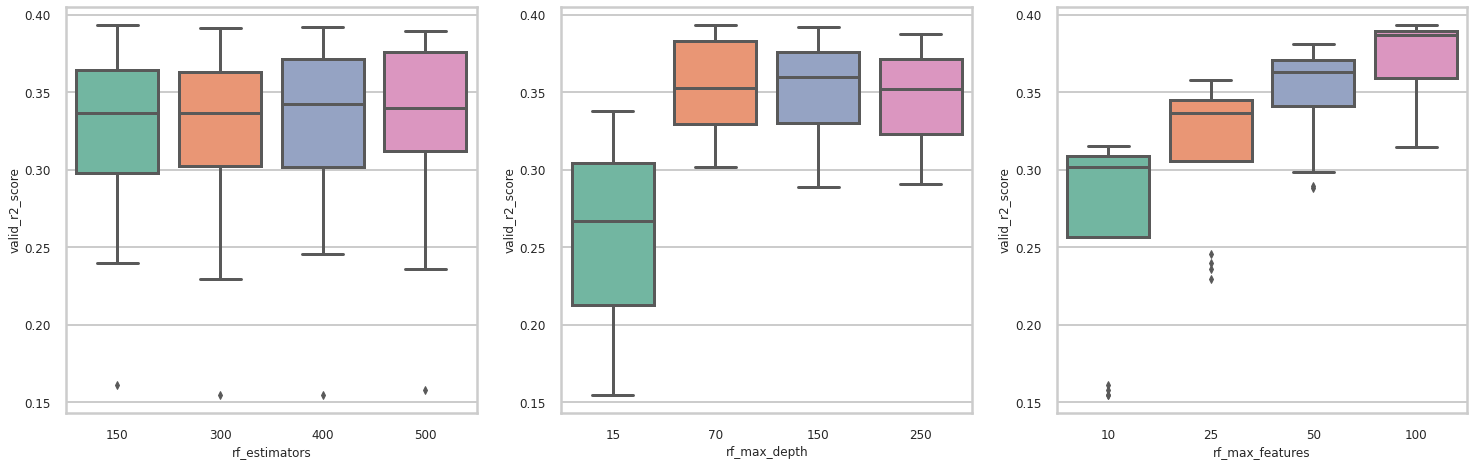

In [51]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.boxplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.boxplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.boxplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

In [53]:

n_estimator = [350]
rf_max_depth = [100]
rf_max_features = [50,100,120,150]


rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in n_estimator:
    for rf_depth in rf_max_depth:
        for rf_feature in rf_max_features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

number of features: 1024


2021-04-28 13:33:46,577 Previous dataset split restored


TIMING: dataset construction took 0.115 s
Loading dataset from disk.
TIMING: dataset construction took 0.029 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:33:53,976 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/868f3478-94d3-4541-acfc-e102c33b934f/model_metadata.json
2021-04-28 13:33:54,590 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/868f3478-94d3-4541-acfc-e102c33b934f/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_868f3478-94d3-4541-acfc-e102c33b934f.tar.gz
rf_estimators: 350, rf_max_depth: 100, rf_max_features: 50, valid_r2: 0.36627742961403387
number of features: 1024


2021-04-28 13:34:07,141 Previous dataset split restored


TIMING: dataset construction took 0.119 s
Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.


2021-04-28 13:34:17,223 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/5a61e481-2549-4433-9bfb-aee0ff6c2260/model_metadata.json
2021-04-28 13:34:17,827 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/5a61e481-2549-4433-9bfb-aee0ff6c2260/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_5a61e481-2549-4433-9bfb-aee0ff6c2260.tar.gz
rf_estimators: 350, rf_max_depth: 100, rf_max_features: 100, valid_r2: 0.39058477054626806
number of features: 1024


2021-04-28 13:34:30,594 Previous dataset split restored


TIMING: dataset construction took 0.118 s
Loading dataset from disk.
TIMING: dataset construction took 0.026 s
Loading dataset from disk.
TIMING: dataset construction took 0.025 s
Loading dataset from disk.


2021-04-28 13:34:41,658 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/bdce4499-faa2-4e1a-8bc7-3b15a907ed77/model_metadata.json
2021-04-28 13:34:42,252 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/bdce4499-faa2-4e1a-8bc7-3b15a907ed77/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_bdce4499-faa2-4e1a-8bc7-3b15a907ed77.tar.gz
rf_estimators: 350, rf_max_depth: 100, rf_max_features: 120, valid_r2: 0.3833490166695299
number of features: 1024


2021-04-28 13:34:54,235 Previous dataset split restored


TIMING: dataset construction took 0.142 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
TIMING: dataset construction took 0.023 s
Loading dataset from disk.


2021-04-28 13:35:06,620 Wrote model metadata to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/19b32ae2-ebef-4b6e-9f20-0b5778cc2fd3/model_metadata.json
2021-04-28 13:35:07,273 Wrote model metrics to file ampl_output/DRD22_Merge_1/RF_ecfp_scaffold_regression/19b32ae2-ebef-4b6e-9f20-0b5778cc2fd3/model_metrics.json


Wrote model tarball to ampl_output/DRD22_Merge_1_model_19b32ae2-ebef-4b6e-9f20-0b5778cc2fd3.tar.gz
rf_estimators: 350, rf_max_depth: 100, rf_max_features: 150, valid_r2: 0.3990361299568338


In [54]:
perf_df2 = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df2.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
3,350,100,150,0.399036
1,350,100,100,0.390585
2,350,100,120,0.383349
0,350,100,50,0.366277


In [55]:
#  Retrieve model metadata and performance metrics stored in the filesystem from a hyperparameter search run.
cmp.get_filesystem_perf_results('ampl_output', pred_type='regression').sort_values(by='valid_r2_score', ascending=False)

Found data for 70 models under ampl_output


,model_uuid,ampl_version,model_type,dataset_key,featurizer,splitter,model_score_type,feature_transform_type,learning_rate,dropouts,layer_sizes,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_choice_score,train_r2_score,train_rms_score,train_mae_score,train_num_compounds,valid_r2_score,valid_rms_score,valid_mae_score,valid_num_compounds,test_r2_score,test_rms_score,test_mae_score,test_num_compounds
68,19b32ae2-ebef-4b6e-9f20-0b5778cc2fd3,1.1.0,RF,DRD22_Merge_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,350,150,100.0,NaN,NaN,0.399036,0.931478,0.340034,0.226223,1834,0.399036,0.969687,0.768046,229,0.417636,0.804461,0.611966,230
49,bb994340-7542-47bf-9964-6b869e69ef37,1.1.0,RF,DRD22_Merge_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,150,100,70.0,NaN,NaN,0.393338,0.928247,0.347959,0.228848,1834,0.393338,0.974273,0.772613,229,0.425132,0.799267,0.610327,230
16,d9e1c93b-55b2-448e-9107-7c395e716776,1.1.0,RF,DRD22_Merge_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,400,100,150.0,NaN,NaN,0.391837,0.930910,0.341441,0.226266,1834,0.391837,0.975478,0.774544,229,0.424441,0.799747,0.613543,230
22,fc76f48d-c7a4-4c3d-bc0f-609bb59601a2,1.1.0,RF,DRD22_Merge_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,300,100,150.0,NaN,NaN,0.391456,0.929992,0.343703,0.225163,1834,0.391456,0.975783,0.775275,229,0.428702,0.796781,0.608733,230
32,5a61e481-2549-4433-9bfb-aee0ff6c2260,1.1.0,RF,DRD22_Merge_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,350,100,100.0,NaN,NaN,0.390585,0.930789,0.341741,0.226224,1834,0.390585,0.976482,0.775438,229,0.427527,0.797600,0.609198,230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,a60a531f-d38c-4500-a97e-2fb902345538,1.1.0,RF,DRD22_Merge_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,300,25,15.0,NaN,NaN,0.229484,0.705881,0.704482,0.538707,1834,0.229484,1.097990,0.909685,229,0.350059,0.849855,0.661212,230
26,035bd59d-4a4c-425c-8ac7-6cff15b5dd4c,1.1.0,RF,DRD22_Merge_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,150,10,15.0,NaN,NaN,0.161102,0.613756,0.807308,0.622682,1834,0.161102,1.145676,0.953064,229,0.324024,0.866709,0.680555,230
10,687089c6-f891-44b8-80db-0817f182b000,1.1.0,RF,DRD22_Merge_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,500,10,15.0,NaN,NaN,0.157754,0.620340,0.800398,0.619583,1834,0.157754,1.147961,0.959467,229,0.326509,0.865114,0.680118,230
4,8438963b-3c45-449f-9cff-67f23cc48986,1.1.0,RF,DRD22_Merge_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,400,10,15.0,NaN,NaN,0.154665,0.619914,0.800846,0.620517,1834,0.154665,1.150064,0.960817,229,0.317402,0.870944,0.685203,230


In [56]:
# save the best model
cmp.copy_best_filesystem_models(pred_type="regression", dest_dir=working_dir, 
                                result_dir='ampl_output', force_update=False)

Found data for 70 models under ampl_output
Copied DRD22_Merge_1_model_19b32ae2-ebef-4b6e-9f20-0b5778cc2fd3.tar.gz


,model_uuid,ampl_version,model_type,dataset_key,featurizer,splitter,model_score_type,feature_transform_type,learning_rate,dropouts,layer_sizes,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_choice_score,train_r2_score,train_rms_score,train_mae_score,train_num_compounds,valid_r2_score,valid_rms_score,valid_mae_score,valid_num_compounds,test_r2_score,test_rms_score,test_mae_score,test_num_compounds
68,19b32ae2-ebef-4b6e-9f20-0b5778cc2fd3,1.1.0,RF,DRD22_Merge_1.csv,ecfp,scaffold,r2,normalization,NaN,NaN,NaN,NaN,NaN,350,150,100.0,NaN,NaN,0.399036,0.931478,0.340034,0.226223,1834,0.399036,0.969687,0.768046,229,0.417636,0.804461,0.611966,230


In [ ]:
#TEST

In [57]:
! pip install molvs
from atomsci.ddm.pipeline import predict_from_model

In [61]:
test = predict_from_model.predict_from_model_file(model_path='DRD22_Merge_1_model_19b32ae2-ebef-4b6e-9f20-0b5778cc2fd3.tar.gz',
                            input_df = df_avg,
                            id_col='compound_id',
                            smiles_col='base_rdkit_smiles',
                            response_col='VALUE_NUM_mean',
                            is_featurized=False,
                            dont_standardize=True)

Featurization = DynamicFeaturization with ecfp features
number of features: 1024
TIMING: dataset construction took 0.169 s
Loading dataset from disk.


In [62]:
test

,compound_id,base_rdkit_smiles,VALUE_NUM_mean_actual,VALUE_NUM_mean_pred,VALUE_NUM_mean_std
1880,10495881,c1ccc(-c2ncc(CN3CCN(c4cccnc4)CC3)[nH]2)cc1,6.52871,6.509760,0.653602
2073,10524751,CCCN(CCC)C1CCC(=C(C#Cc2ccccc2)C#Cc2ccccc2)CC1,5.28400,5.529683,0.775128
1739,10571274,COc1cccc(OC)c1-c1cccc2c1-c1cccc3c1[C@@H](C2)N(...,5.69250,5.946270,0.467495
2030,10706626,CN1CCc2ccc3c4c2[C@H]1Cc1cccc(c1-4)[C@H]3N,6.58336,6.293070,0.938026
1758,10780942,Clc1ccccc1OCCNCCCOc1ccccc1,6.95001,6.891990,0.412603
...,...,...,...,...,...
1418,CHEMBL98945,CCn1ncc2c1-c1c(Cl)sc(Cl)c1CCC2,6.31000,6.270466,0.635405
2229,CHEMBL99198,O=C(NCCCCN1CCC[C@H]2c3cccc(O)c3CC[C@@H]21)c1cc...,7.60000,7.205155,0.824856
1801,CHEMBL99355,CCCN1CCOC2=C1C=S(O)C1=C2CC(=O)CC1,6.71000,6.505955,0.754937
2095,CHEMBL99649,Cc1sc(C)c2c1CCCc1cnn(C(C)C)c1-2,6.26000,6.315306,0.827890


In [64]:
from sklearn.metrics import r2_score, mean_squared_error
print(r2_score(test.VALUE_NUM_mean_actual, test.VALUE_NUM_mean_pred))
print(mean_squared_error(test.VALUE_NUM_mean_actual, test.VALUE_NUM_mean_pred))

0.8476755454842496
0.2512977783313263


In [ ]:
#PEER TESTING

In [65]:
! pip install molvs

In [66]:
from atomsci.ddm.pipeline import predict_from_model

In [67]:
! wget https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/HTR2A_cur.csv

--2021-04-28 13:49:26--  https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/HTR2A_cur.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 343123 (335K) [text/plain]
Saving to: ‘HTR2A_cur.csv’

HTR2A_cur.csv       100%[===================>] 335.08K  --.-KB/s    in 0.03s   

2021-04-28 13:49:26 (9.48 MB/s) - ‘HTR2A_cur.csv’ saved [343123/343123]



In [68]:
df_test = pd.read_csv('HTR2A_cur.csv',index_col=0)
df_test

,index,compound_id,base_rdkit_smiles,relation,pXC50,active,VALUE_NUM_std,Perc_Var,mol_wt,VALUE_NUM_mean
483,497,CHEMBL4171368,CCC[C@@H](CCO)Nc1nc(N)nc2cc(OC)ccc12,NaN,5.749580,0,NaN,0.0,290.174276,5.749580
876,898,CHEMBL3600828,Clc1ccc(-c2ccc(C#Cc3ccc(OCCN4CCCC4)cc3)nc2)cc1,NaN,6.301030,0,0.0,0.0,402.149891,6.301030
851,872,CHEMBL178870,Nc1ccc(S(=O)(=O)n2cc(C3CCNCC3)c3ccc(Cl)cc32)cc1,NaN,6.270000,0,NaN,0.0,389.096476,6.270000
1432,1459,CHEMBL74766,c1ccc2c(c1)Cc1ccccc1C21CCCNC1,NaN,7.000000,0,NaN,0.0,249.151750,7.000000
1012,1038,44287208,Clc1cccc2cc3n(c12)CCNC3,NaN,6.481490,0,NaN,0.0,206.061076,6.481490
...,...,...,...,...,...,...,...,...,...,...
1586,1615,CHEMBL4209705,CCNC(=O)c1ccnc(OCCCCN2CCC(c3noc4cc(F)ccc34)CC2)c1,NaN,7.170696,1,NaN,0.0,440.222369,7.170696
1394,1421,CHEMBL187888,C[C@@H]1CNC[C@H]2Cc3ccc(C#N)cc3N12,NaN,6.960000,0,NaN,0.0,213.126597,6.960000
449,463,CHEMBL1643858,CC(=O)N(C)c1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C...,NaN,5.690000,0,NaN,0.0,406.211724,5.690000
2398,2442,66801028,O=S(=O)(NCCCN1CCC(c2noc3cc(F)ccc23)CC1)c1ccc(O...,NaN,8.420220,1,NaN,0.0,501.134540,8.420220


In [69]:
test_peer = predict_from_model.predict_from_model_file(model_path='DRD22_Merge_1_model_19b32ae2-ebef-4b6e-9f20-0b5778cc2fd3.tar.gz',
                            input_df = df_test,
                            id_col='compound_id',
                            smiles_col='base_rdkit_smiles',
                            response_col='VALUE_NUM_mean',
                            is_featurized=False,
                            dont_standardize=True)

Featurization = DynamicFeaturization with ecfp features
number of features: 1024
TIMING: dataset construction took 0.208 s
Loading dataset from disk.


In [70]:
test_peer

,compound_id,base_rdkit_smiles,VALUE_NUM_mean_actual,VALUE_NUM_mean_pred,VALUE_NUM_mean_std
1883,10017556,CC(C)Oc1cc2c(cc1Br)C(C)CNCC2,7.013230,5.655567,0.873963
1448,10022781,O=C1c2ccoc2CCC1CCN1CCC(c2noc3cc(F)ccc23)CC1,9.250260,7.406086,0.936431
2575,10042602,Cc1cccc(N2CCN(CCc3ccc4nn[nH]c4c3)CC2)c1C,8.289880,6.849045,1.012010
2697,10064386,COc1cc2c(cc1I)C(C)CNCC2,7.214670,5.691993,1.027535
107,10088453,COc1ccccc1N1CCN(CCc2ccc3nn[nH]c3c2)CC1,6.850010,7.139070,0.885884
...,...,...,...,...,...
632,CHEMBL96471,c1ccc(C2CCN(CC3C[C@@H]4c5ccccc5Cc5ccccc5[C@H]4...,5.960000,6.812296,0.841010
139,CHEMBL96732,CN(C)CC1C[C@H]2c3ccccc3Cc3ccccc3[C@H]2O1,6.990000,7.123774,0.575114
2410,CHEMBL96883,CC(N)Cn1ccc2cc(F)ccc21,6.800000,5.971202,1.095709
2571,CHEMBL97450,CCCCCCCCCOc1ccc2[nH]cc(CCN)c2c1,6.590000,8.674001,2.929648


In [71]:
print(r2_score(test_peer.VALUE_NUM_mean_actual, test_peer.VALUE_NUM_mean_pred))
print(mean_squared_error(test_peer.VALUE_NUM_mean_actual, test_peer.VALUE_NUM_mean_pred))

-0.09119240491045444
1.7463408498720283
